In [18]:
import math
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import time
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('xy_train.csv')
X_test_df = pd.read_csv('x_test.csv')
Y_test_df = pd.read_csv('y_test.csv')

In [3]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
X_test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

So, training data has 177 missing values for Age, 687 missing values for Cabin, 2 missing values from Embarked and test data has 86 missing values for Age, 327 missing values for Cabin and 1 missing value for Fare. Since a large portion of Cabin values are missing, so it can be ignored. To handle missing values for Age, replace missing values with average Age computed from TRAINING SET. To handle missing values for Fare, replace missing values with most frequent occuring Fare in TRAINING SET. To handle missing values for Embarked,replace missing values with most frequent occuring Embarked in TRAINING SET. PassengerId, Name, Ticket Number should have no role in deciding whether person survived or not, so it is ignored

In [5]:
most_frequent_fare = train_df['Fare'].mode()[0]
most_frequent_embarked = train_df['Embarked'].mode()[0]
most_frequent_cabin = train_df['Cabin'].mode()[0]

In [7]:
avg_age = train_df['Age'].mean()
X_train = train_df.drop(['PassengerId','Name','Ticket','Survived','Cabin'], axis=1)
Y_train = train_df['Survived'].values
X_test = X_test_df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
Y_test = Y_test_df['Survived'].values
X_train.fillna({'Age':avg_age, 'Fare':most_frequent_fare, 'Embarked':most_frequent_embarked}, inplace=True)
X_test.fillna({'Age':avg_age, 'Fare':most_frequent_fare, 'Embarked':most_frequent_embarked}, inplace=True)

Use LabelEncoder to convert string categorical values into corresponding numerical values

In [8]:
le = preprocessing.LabelEncoder() 
le.fit(X_train['Sex'])
X_train.loc[:,'Sex'] = le.transform(X_train['Sex'])
X_test.loc[:,'Sex'] = le.transform(X_test['Sex'])
le.fit(X_train['Embarked'])
X_train.loc[:,'Embarked'] = le.transform(X_train['Embarked'])
X_test.loc[:,'Embarked'] = le.transform(X_test['Embarked'])

Split test set into test set and validation set for hyperparameter tuning

In [9]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.1, random_state=1)

Use MinMaxScalar for feature scaling

In [10]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(891, 7)
(891,)
(376, 7)
(376,)
(42, 7)
(42,)


Add one extra column containg all 1s  in X_train, X_val, X_test for bias

In [12]:
X_train = np.hstack((np.ones(X_train.shape[0]).reshape(X_train.shape[0],1), X_train))
X_test = np.hstack((np.ones(X_test.shape[0]).reshape(X_test.shape[0],1), X_test))
X_val = np.hstack((np.ones(X_val.shape[0]).reshape(X_val.shape[0],1), X_val))
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
Y_val = Y_val.reshape(-1,1)
m = X_train.shape[0]

Initailize theta with all zeros

In [13]:
theta = np.zeros((X_train.shape[1],1))

Logistic Regression cost function with regularization

In [14]:
def compute_cost(m, hx, lamb):
    cost = -(1/m)* np.sum((Y_train*np.log(hx)) + (1-Y_train)*(np.log(1-hx))) + (lamb/(2*m)) * np.sum(np.square(theta))
    return cost

Hyperparameter tuning on validation set. Get best value for hyperparameter learning rate alpha and regularization parameter lambda

In [15]:
num_iter = 100000
alphas = [0.1, 0.01, 0.001]
lambs = [1, 10, 100]
max_acc = 0
best_alpha, best_lamb = 0, 0
for alpha in alphas:
    for lamb in lambs:
        for i in range(num_iter):
            hx = 1/ (1 + np.exp(-np.dot(X_train,theta)))
            cost = compute_cost(m,hx,lamb)
            theta = theta - (alpha * ((1/m)*np.dot(X_train.T, (hx-Y_train))  + ((lamb/m) * theta)))
        hx = 1/ (1 + np.exp(-np.dot(X_val,theta)))
        Y_pred = (hx>0.5).astype(int)
        acc = np.mean(Y_val==Y_pred)
        if acc >= max_acc:
            max_acc = acc
            best_alpha = alpha
            best_lamb = lamb

In [16]:
print(best_alpha, best_lamb)

0.001 10


In [20]:
theta = np.zeros((X_train.shape[1],1))

In [21]:
num_iter = 100000
alpha = best_alpha
lamb = best_lamb
cost_history = []
for i in range(num_iter):
    hx = 1/ (1 + np.exp(-np.dot(X_train,theta)))
    cost = compute_cost(m,hx,lamb)
    cost_history.append(cost)
    if i % 10000 == 0:
        print(cost)
    theta = theta - (alpha * ((1/m)*np.dot(X_train.T, (hx-Y_train))  + ((lamb/m) * theta)))
    

0.6931471805599454
0.5645326913172971
0.5378332972644251
0.5265863038239457
0.521428916743642
0.5188719371265496
0.5175140999118036
0.5167485205057277
0.5162936965062557
0.5160109194681047


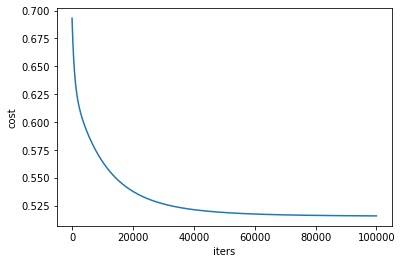

In [26]:
plt.plot(cost_history)
plt.xlabel('iters')
plt.ylabel('cost')
plt.show()

Compute sigmoid output on test set

In [27]:
hx = 1/ (1 + np.exp(-np.dot(X_test,theta)))

If sigmoid output is greater than 0.5 then predict as survived else not survived

In [28]:
pred = (hx>0.5).astype(int)

In [29]:
print(np.mean(Y_test==pred))

1.0
